# IPC PROJECT

## Libraries

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import pandas as pd
import pdb
import wfdb

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
from pywt import wavedec
import pywt
import numpy as np
import pandas as pd
from scipy.stats import iqr
import sys
import copy
from scipy.signal import detrend
import copy 

## Data

In [100]:
#grab data from https://www.physionet.org/physiobank/database/apnea-ecg/
record = wfdb.rdrecord('100', pn_dir='mitdb')
data = pd.DataFrame(record.p_signal)

#annotation = wfdb.rdann('a01', 'apn', pb_dir='apnea-ecg/')

data.to_pickle('mitdb.pkl')

## constants

In [101]:
FS = 100 #sampling rate

NUM_SAMPLES_BLOCK = 3000 # blocks of samples for each iteration

#number of bits that can be used to represent the run length. a 4 bit number corresponds to 
#a max value of 2**4-1 = 15 bits, which is equal to 32767. so in other words, if the entire
#binary map was all 1 or all 0, NUM_BITS_RUN_LEN=4 means we can represent a run of 32767
#consecutive 0's or 1's
NUM_BITS_RUN_LEN = 4

#don't allow the PRD to be greater than 5%
MAX_PRD = 0.4

#define the threshold percentage for retaining energy of wavelet coefficients
#separate percentage for approximate coefficients and separate for detailed
THRESH_PERC_APPROX = 0.999
THRESH_PERC_D5 = 0.97
THRESH_PERC_D4_D1 = 0.85

## Wavelet Decomposition Function

In [102]:
def wavelet_decomposition(sig, wavelet):
    cA5, cD5, cD4, cD3, cD2, cD1 = wavedec(sig, wavelet , level=5)
    coeffs = {'cA5': cA5, 'cD5': cD5, 'cD4': cD4, 'cD3': cD3, 'cD2': cD2, 'cD1': cD1}

    #plot stuff
    do_plot = False

    if do_plot:
        print('\n\n')
        print('Plot of wavelet decomposition for all levels')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs['cA5'])
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(coeffs['cD5'])
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(coeffs['cD4'])
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(coeffs['cD3'])
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(coeffs['cD2'])
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(coeffs['cD1'])
        plt.title('cD1')
        plt.xlabel('Index')

        plt.tight_layout()
        plt.savefig('figs/wavelet_decomposition.png', dpi=150)
        plt.show()

    return coeffs

## Wavelet Reconstruction Function

In [103]:
def wavelet_reconstruction(coeffs, orig_data, wavelet, CR, do_plot=False):
    reconstructed = pywt.waverec([coeffs['cA5'], coeffs['cD5'], coeffs['cD4'], coeffs['cD3'], 
                                    coeffs['cD2'], coeffs['cD1']], wavelet)


    if do_plot:
        print('\n\n')
        print('Plot of original signal through the process of compression and decompression:')
        
        t = [i/FS for i in range(NUM_SAMPLES_BLOCK)]
        plt.subplots(figsize=(16,9))
        plt.plot(t, orig_data, label='Original Signal')
        plt.plot(t, reconstructed, label='Reconstructed Signal')
        plt.title('Compression Ratio: %.1f' % CR)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        plt.tight_layout()
        plt.legend(loc=1)
        axes = plt.gca()
        axes.set_xlim((17, 21.5))
        plt.savefig('figs/reconstructed.png', dpi=150)
        plt.show()

    return reconstructed

## Thresholding Function

In [104]:
def threshold_energy(coeffs, do_plot=False):
    #make a deep copy of coeffs to retain the original version
    coeffs_orig = copy.deepcopy(coeffs)

    binary_map = {}
    nonzero_coeff_count = {}

    for key in coeffs.keys():
        #sort the absolute value of the coefficients in descending order
        tmp_coeffs = np.sort(np.abs(coeffs[key]))[::-1]

        #calculate the threshold for retaining some percentage of the energy
        if key == 'cA5':
            thresh_perc = THRESH_PERC_APPROX
        elif key == 'cD5':
            thresh_perc = THRESH_PERC_D5
        else:
            thresh_perc = THRESH_PERC_D4_D1

        energy_thresholded = thresh_perc*energy(tmp_coeffs)
        energy_tmp = 0
        for coeff in tmp_coeffs:
            energy_tmp = energy_tmp + coeff**2

            if energy_tmp >= energy_thresholded:
                threshold = coeff
                break

        #set any coefficients below the threshold to zero
        tmp_coeffs = coeffs[key]
        inds_to_zero = np.where((tmp_coeffs < threshold) & (tmp_coeffs > -threshold))[0]
        tmp_coeffs[inds_to_zero] = 0

        #create the binary map
        binary_map_tmp = np.ones(len(coeffs[key])).astype(int)
        binary_map_tmp[inds_to_zero] = 0

        #update the various dictionaries
        coeffs[key] = tmp_coeffs
        binary_map[key] = binary_map_tmp
        nonzero_coeff_count[key] = len(tmp_coeffs)


    if do_plot:
        print('\n\n')
        print('Plot of thresholded vs unthresholded coefficients:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs_orig['cA5'], label='Original')
        plt.plot(coeffs['cA5'], label='Thresholded')
        plt.legend(loc=1)
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(coeffs_orig['cD5'], label='Original')
        plt.plot(coeffs['cD5'], label='Thresholded')
        plt.legend(loc=1)
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(coeffs_orig['cD4'], label='Original')
        plt.plot(coeffs['cD4'], label='Thresholded')
        plt.legend(loc=1)
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(coeffs_orig['cD3'], label='Original')
        plt.plot(coeffs['cD3'], label='Thresholded')
        plt.legend(loc=1)
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(coeffs_orig['cD2'], label='Original')
        plt.plot(coeffs['cD2'], label='Thresholded')
        plt.legend(loc=1)
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(coeffs_orig['cD1'], label='Original')
        plt.plot(coeffs['cD1'], label='Thresholded')
        plt.legend(loc=1)
        plt.xlabel('Index')

        plt.tight_layout()
        plt.savefig('figs/wavelet_thresholding.png', dpi=150)
        plt.show()

        
    return coeffs, binary_map

## Function to scale the wavelet coefficients to the [0,1] range. This involves two scaling factors: a shift factor and a multiplication factor.

In [105]:
def scale_coeffs(coeffs, do_plot=False):
    coeffs_scaled = {}
    scaling_factors = {}

    for key in coeffs.keys():
        shift_factor = np.min(coeffs[key])
        coeffs_tmp = coeffs[key]-shift_factor

        scale_factor = np.max(coeffs_tmp)
        coeffs_tmp = coeffs_tmp/scale_factor

        scaling_factors[key] = {'shift_factor': shift_factor, 'scale_factor': scale_factor}
        coeffs_scaled[key] = coeffs_tmp


    if do_plot:
        print('\n\n')
        print('Plot of scaled coefficients:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs_scaled['cA5'])
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(coeffs_scaled['cD5'])
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(coeffs_scaled['cD4'])
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(coeffs_scaled['cD3'])
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(coeffs_scaled['cD2'])
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(coeffs_scaled['cD1'])
        plt.title('cD1')
        plt.xlabel('Index')

        plt.tight_layout()
        plt.savefig('figs/wavelet_scaled.png', dpi=150)
        plt.show()


    return coeffs_scaled, scaling_factors

## Function to unscale the coefficients back to their original scaling

In [106]:
def unscale_coeffs(coeffs_orig, coeffs_reconstructed, scaling_factors, bits, do_plot=False):
    coeffs_unscaled = {}

    for key in coeffs_reconstructed.keys():
        tmp_coeffs_unscaled = coeffs_reconstructed[key]/(2**bits)
        tmp_coeffs_unscaled = tmp_coeffs_unscaled*scaling_factors[key]['scale_factor']
        tmp_coeffs_unscaled = tmp_coeffs_unscaled + scaling_factors[key]['shift_factor']

        #now replace the NaN values with 0
        nan_inds = np.where(np.isnan(tmp_coeffs_unscaled))[0]
        tmp_coeffs_unscaled[nan_inds] = 0

        coeffs_unscaled[key] = tmp_coeffs_unscaled


    if do_plot:
        print('\n\n')
        print('Plot of wavelet coefficients before scaling and after rescaling:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs_orig['cA5'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cA5'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(coeffs_orig['cD5'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD5'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(coeffs_orig['cD4'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD4'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(coeffs_orig['cD3'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD3'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(coeffs_orig['cD2'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD2'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(coeffs_orig['cD1'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD1'], label='After Rescaling')
        plt.legend(loc=1)
        plt.xlabel('Index')

        plt.tight_layout()
        plt.savefig('figs/wavelet_rescaled.png', dpi=150)
        plt.show()



    return coeffs_unscaled

## Function to calculate the lowest possible number of bits to quantize the wavelet coefficients such that the PRD is above the threshold. 
#### quantize the signal starting at 8 bits, then unquantize and reconstruct the signal, and then calculate the PRD. Repeat with 1 fewer bit (ie, 7 bits), and so on...

In [107]:
def calculate_num_bits(orig_sig, coeffs_scaled, scaling_factors, do_plot=False):
    #starting at 8 bits, keep decreasing the number of bits in the quantization
    #until the PRD is above some threshold
    num_bits = 9

    #initialize PRD to 0 so the while loop can run
    PRD = 0

    #keep track of PRD per number of bits
    PRD_dict = {}

    if do_plot:
        plt.subplots(figsize=(16,9))
        t = [i/FS for i in range(NUM_SAMPLES_BLOCK)]
        plt.plot(t, orig_sig, label='Original Signal')


    while (num_bits >= 5) and (PRD <= MAX_PRD):
        #decrement the number of bits
        num_bits = num_bits-1

        coeffs_quantized = do_quantization(coeffs_scaled, num_bits)

        #rescale the coefficients
        coeffs_unscaled = unscale_coeffs(None, coeffs_quantized, scaling_factors, num_bits)

        #do the inverse dwt
        data_reconstructed = wavelet_reconstruction(coeffs_unscaled, None,wavelet, None)

        #calculate PRD
        PRD = calculate_PRD(orig_sig, data_reconstructed)
        PRD_dict[num_bits] = PRD

        #plot the reconstructed signals 
        if do_plot:
            if PRD <= MAX_PRD:
                plt.plot(t, data_reconstructed, label='Reconstructed @ %i Bits, PRD = %.2f' % (num_bits, PRD))

    #if we went over the PRD, go back up by one bit
    if PRD > MAX_PRD:
        num_bits = num_bits+1
        PRD = PRD_dict[num_bits]

    #plot some more stuff
    if do_plot:
        print('\n\n')
        print('Plots of reconstructed signals vs number of bits used for quantization:')
        plt.legend(loc=1)
        plt.tight_layout()
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        axes = plt.gca()
        axes.set_xlim((17, 21.5))
        plt.savefig('figs/PRD.png', dpi=150)
        plt.show()


    return num_bits, PRD

## Combining wavelet coefficients into single List

In [108]:
def combine_coefficients(coeffs, binary_map=None):
    coeffs_combined = []

    #loop through each of the wavelet decompositions and remove zero values based 
    #on the binary map
    if binary_map is not None:
        for key in coeffs.keys():
            inds_to_keep = np.where(binary_map[key]==1)[0]
            coeffs[key] = coeffs[key][inds_to_keep]

    #add in each array to coeffs_combined
    coeffs_combined.extend(coeffs['cA5'])
    coeffs_combined.extend(coeffs['cD5'])
    coeffs_combined.extend(coeffs['cD4'])
    coeffs_combined.extend(coeffs['cD3'])
    coeffs_combined.extend(coeffs['cD2'])
    coeffs_combined.extend(coeffs['cD1'])

    return coeffs_combined

## Remapping Coefficients

In [109]:
def remap_coeffs(sep_coeffs, coeffs, binary_map):
    coeffs_remapped = np.zeros(len(binary_map))*np.nan
    inds_to_set = np.where(binary_map==1)[0]
    coeffs_remapped[inds_to_set] = coeffs

    wavelet_remapped = {}
    counter = 0
    wavelet_remapped['cA5'] = coeffs_remapped[counter:counter+len(sep_coeffs['cA5'])]

    counter = counter + len(sep_coeffs['cA5'])
    wavelet_remapped['cD5'] = coeffs_remapped[counter:counter+len(sep_coeffs['cD5'])]

    counter = counter + len(sep_coeffs['cD5'])
    wavelet_remapped['cD4'] = coeffs_remapped[counter:counter+len(sep_coeffs['cD4'])]

    counter = counter + len(sep_coeffs['cD4'])
    wavelet_remapped['cD3'] = coeffs_remapped[counter:counter+len(sep_coeffs['cD3'])]

    counter = counter + len(sep_coeffs['cD3'])
    wavelet_remapped['cD2'] = coeffs_remapped[counter:counter+len(sep_coeffs['cD2'])]

    counter = counter + len(sep_coeffs['cD2'])
    wavelet_remapped['cD1'] = coeffs_remapped[counter:counter+len(sep_coeffs['cD1'])]

    return wavelet_remapped

## Quantization

In [110]:
def do_quantization(coeffs, bits, do_plot=False):
    quantized_coeffs = {}

    for key in coeffs.keys():
        sig = coeffs[key]
        sig = sig*(2**bits-1)
        sig = np.round(sig)
        sig = np.array(sig).astype(int)

        quantized_coeffs[key] = sig


    if do_plot:
        print('\n\n')
        print('Plot of quantized coefficients:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(quantized_coeffs['cA5'])
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(quantized_coeffs['cD5'])
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(quantized_coeffs['cD4'])
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(quantized_coeffs['cD3'])
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(quantized_coeffs['cD2'])
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(quantized_coeffs['cD1'])
        plt.title('cD1')
        plt.xlabel('Index')

        plt.tight_layout()
        plt.savefig('figs/wavelet_quantized.png', dpi=150)
        plt.show()

        
    return quantized_coeffs

## Function to compress the binary map using variable length run-length encoding (RLE).

In [111]:
def compress_binary_map(binary_map):
    #define a state machine that loops through each entry in the binary map and 
    #creates the compressed representation. 

    #the last run count won't be included in the compressed representation, so 
    #just append one more value at the end of the binary map to trigger the last 
    #compression value. make a local deep copy so that the original is not affected
    binary_map = copy.deepcopy(binary_map)
    binary_map.append(int(not binary_map[-1]))


    CURRENT_STATE = binary_map[0]
    run_count = 0
    binary_string = ''

    #loop through each value in the binary map
    for val in binary_map:

        #if the current binary map value is the same as the previous one, just increment the run count
        if val == CURRENT_STATE:
            run_count = run_count + 1

        #otherwise, encode the current run count 
        else:

            #handle cases where run count <= 3
            if run_count == 1:
                binary_string_tmp = '00'

            elif run_count == 2:
                binary_string_tmp = '01'

            elif run_count == 3:
                binary_string_tmp = '10'

            #otherwise, if the run count > 3
            else:
                #calculate the number bits required to represent the run count
                num_bits_run_count = len(format(run_count, 'b'))

                #build a binary string
                binary_string_tmp = ''

                #first bit represents that the run count > 3
                binary_string_tmp = binary_string_tmp + '11'

                #next 4 bits represent the number of bits that will define the run count
                binary_string_tmp = binary_string_tmp + format(num_bits_run_count, '0%ib' % NUM_BITS_RUN_LEN)

                #next number of bits is variable, and is the actual run count
                #may be up to 15 bits assuming NUM_BITS_RUN_LEN=4
                binary_string_tmp = binary_string_tmp + format(run_count, 'b')

            #print(str(run_count) + ', ' + binary_string_tmp)
            #pdb.set_trace()

            #append the binary string
            binary_string = binary_string + binary_string_tmp

            #reset the run count 
            run_count = 1

        #update the current state
        CURRENT_STATE = val


    #convert the binary string into a buffer of 8 bit bytes 
    byte_array = []
    for i in range(int(len(binary_string)/8)):
        byte_tmp = binary_string[i*8:(i+1)*8]
        byte_tmp = int(byte_tmp, 2)
        byte_array.append(byte_tmp)


    #check if there are any remaining bits that don't divide evenly into 8
    num_bits_last_byte = 8
    if len(binary_string)%8 != 0:
        byte_tmp = binary_string[(i+1)*8:(i+1)*8 + len(binary_string)%8]
        num_bits_last_byte = len(byte_tmp)
        byte_tmp = int(byte_tmp, 2)
        byte_array.append(byte_tmp)


    #return the initial state (ie, the first value in binary map), and the RLE binary map
    return binary_map[0], byte_array, num_bits_last_byte

## Function to decompress the previously compressed binary map

In [112]:
def decompress_binary_map(binary_map_compressed, binary_map_initial_state, num_bits_last_byte):

    #first convert 8 bit numbers into a binary string
    binary_string = ''

    #convert each coefficient value to binary in 8 number of bits
    #note that the very last value in the the binary map may not be
    #a full 8 bits. so convert that based on num_bits_last_byte
    binary_map_len = len(binary_map_compressed)
    for i in range(binary_map_len):
        if i == binary_map_len-1:
            binary_string = binary_string + format(binary_map_compressed[i], '0%ib' % num_bits_last_byte)
        else:
            binary_string = binary_string + format(binary_map_compressed[i], '08b')


    #define a state machine that loops through each entry in the binary map and 
    #creates the uncompressed representation. 
    READ_HEADER = 0
    READ_NUM_BITS = 1
    READ_RUN_LEN = 2
    state = READ_HEADER

    run_type = binary_map_initial_state
    header = ''
    binary_array = np.array([])


    #loop through each value in the binary map
    for val in binary_string:

        #read the header
        if state == READ_HEADER:
            header = header + val

            if len(header) == 2:
                #run count 1
                if header == '00':
                    binary_array = np.concatenate((binary_array, np.ones(1)*run_type))
                    run_type = int(not run_type)
                    state = READ_HEADER

                #run count 2
                if header == '01':
                    binary_array = np.concatenate((binary_array, np.ones(2)*run_type))
                    run_type = int(not run_type)
                    state = READ_HEADER

                #run count 3
                if header == '10':
                    binary_array = np.concatenate((binary_array, np.ones(3)*run_type))
                    run_type = int(not run_type)
                    state = READ_HEADER

                #run count > 3
                if header == '11':
                    state = READ_NUM_BITS
                    num_bits = ''


                #reset header 
                header = ''

            continue

        #read number of bits
        if state == READ_NUM_BITS:


            num_bits = num_bits + val

            if len(num_bits) == 4:
                num_bits_run_len = int(num_bits, 2)
                run_len = ''

                state = READ_RUN_LEN

            continue


        #read run length
        if state == READ_RUN_LEN:
            run_len = run_len + val

            if len(run_len) == num_bits_run_len:
                run_len = int(run_len, 2)
                binary_array = np.concatenate((binary_array, np.ones(run_len)*run_type))
                run_type = int(not run_type)
                state = READ_HEADER

            continue


    return binary_array

## Function to calculate the compression ratio.

In [113]:
def calculate_compression_ratio(coeffs_compressed, scaling_factors, binary_map_compressed, binary_map_initial_state):

    #each value in the compressed coefficients is 8 bits
    num_bits_compressed = len(coeffs_compressed)*8

    #the number of bits in the last byte of the compressed coeffs is 8
    #and another 8 bits for the last byte of the compressed binary map
    num_bits_compressed = num_bits_compressed + 16

    #each set of scaling factors has 2 float values, and each float value is 32 bits
    num_bits_compressed = num_bits_compressed + len(scaling_factors)*2*32

    #the number of bits corresponds to one byte(quantize)
    num_bits_compressed = num_bits_compressed + 8

    #each value in the compressed binary map is 8 bits
    num_bits_compressed = num_bits_compressed + len(binary_map_compressed)*8

    #the initial state of the binary map is just one bit but assume it's stored as a byte
    num_bits_compressed = num_bits_compressed + 8

    #each of the original data are 16 bits 
    num_bits_uncompressed = NUM_SAMPLES_BLOCK*16

    #get the compression ratio
    compression_ratio = num_bits_uncompressed/num_bits_compressed

    return compression_ratio   

## Function for removing DC offset

In [114]:
def do_detrend(sig, do_plot=False):
    detrended = detrend(sig)

    if do_plot:
        print('\n\n')
        print('Original and detrended signal:')
        
        t = [i/FS for i in range(NUM_SAMPLES_BLOCK)]
        plt.subplots(figsize=(16,9))
        plt.plot(t, sig, label='Original Signal')
        plt.plot(t, detrended, label='Detrended Signal')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        plt.tight_layout()
        plt.legend(loc=1)
        axes = plt.gca()
        axes.set_xlim((17, 21.5))
        plt.savefig('figs/detrending.png', dpi=150)
        plt.show()

    return detrended

## Energy

In [115]:
def energy(sig):
    return np.sum(sig**2)

## PRD

In [116]:
def calculate_PRD(orig_sig, reconstructed_sig):
    num = np.sum((orig_sig - reconstructed_sig)**2)
    den = np.sum(orig_sig**2)

    PRD = np.sqrt(num/den)

    return PRD

## Compressing Wavelet Coefficients using Huffman-Coding

In [117]:
from heapq import heappush, heappop, heapify
from collections import defaultdict

In [118]:
def create_prob_model(message):
    """
    Create an alphabeth based on the symbols in the message, and
    attach a frequency to each symbol
    """
    
    prob_model = defaultdict(int) # Every new key is given a default value of 0
    for char in message:
        prob_model[char] += 1 / len(message)
        
    return prob_model

In [119]:
def huff_encode(message):
    """Huffman encoding of the input message.
    
    Args:
        message: String, a sequence of characters (symbols)
                          
    Returns:
        source_code: Dict where every entry is {symbol: (frequency, codeword)}
        encoded_message: String, bitstream of the encoded input message using the source_code.
    
    """
    
    prob_model = create_prob_model(message)
    
    heap = [[freq, [sym, ""]] for sym, freq in prob_model.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    symbol_code_pairs = sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))
    
    source_code = {}
    for pair in symbol_code_pairs:
        symbol = pair[0]
        codeword = pair[1]
        source_code[symbol] = codeword
    
    encoded_message = ''
    for symbol in message:
        encoded_message += source_code[symbol]
    source_code = {value : key for (key, value) in source_code.items()}
    return source_code, encoded_message

## Decompressing Wavelet coefficients using Huffman-coding

In [120]:
def huff_decode (dictionary, text):
    if text:
        k = next(k for k in dictionary if text.startswith(k))
        return str(dictionary[k]) + " "+  huff_decode(dictionary, text[len(k):])
    return ""

# Final Function




Original and detrended signal:


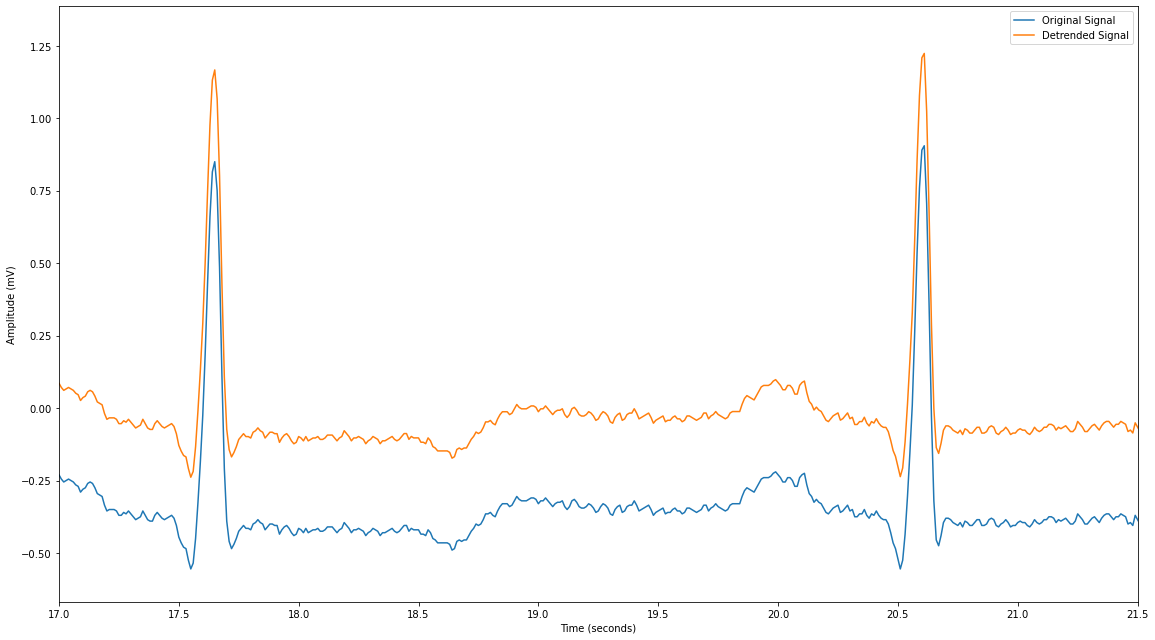




Plot of thresholded vs unthresholded coefficients:


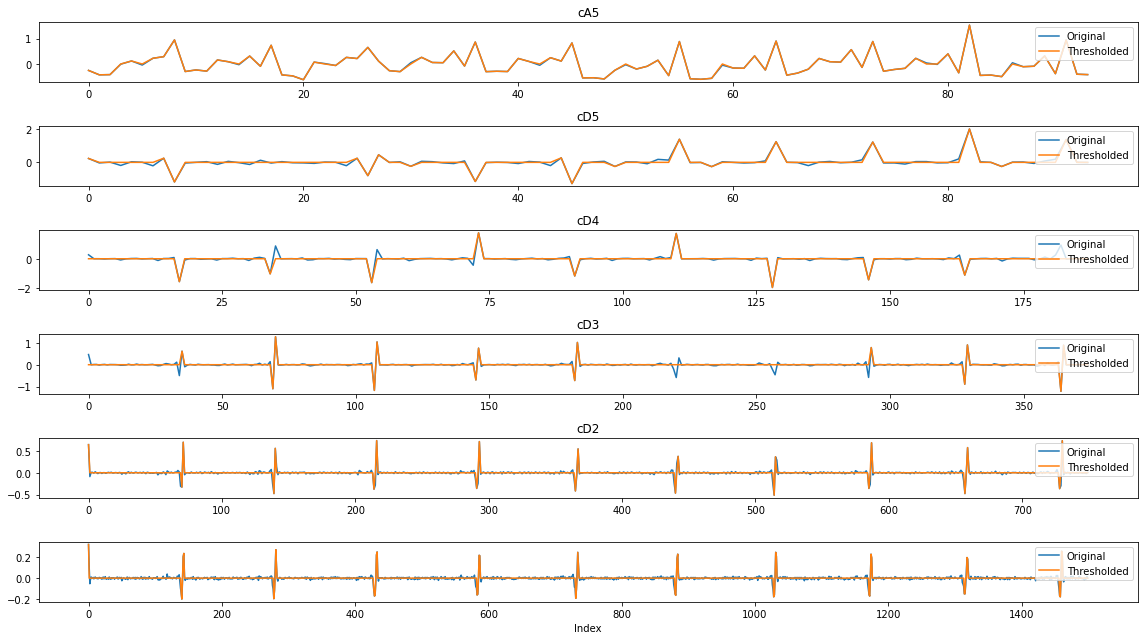




Plot of quantized coefficients:


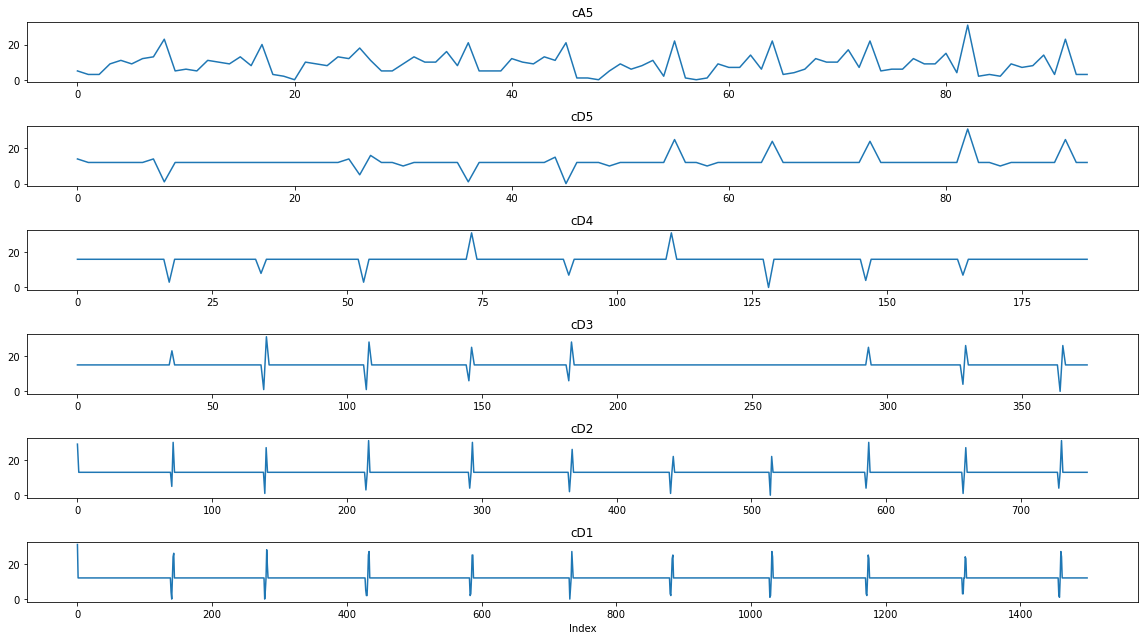




Plot of original signal through the process of compression and decompression:


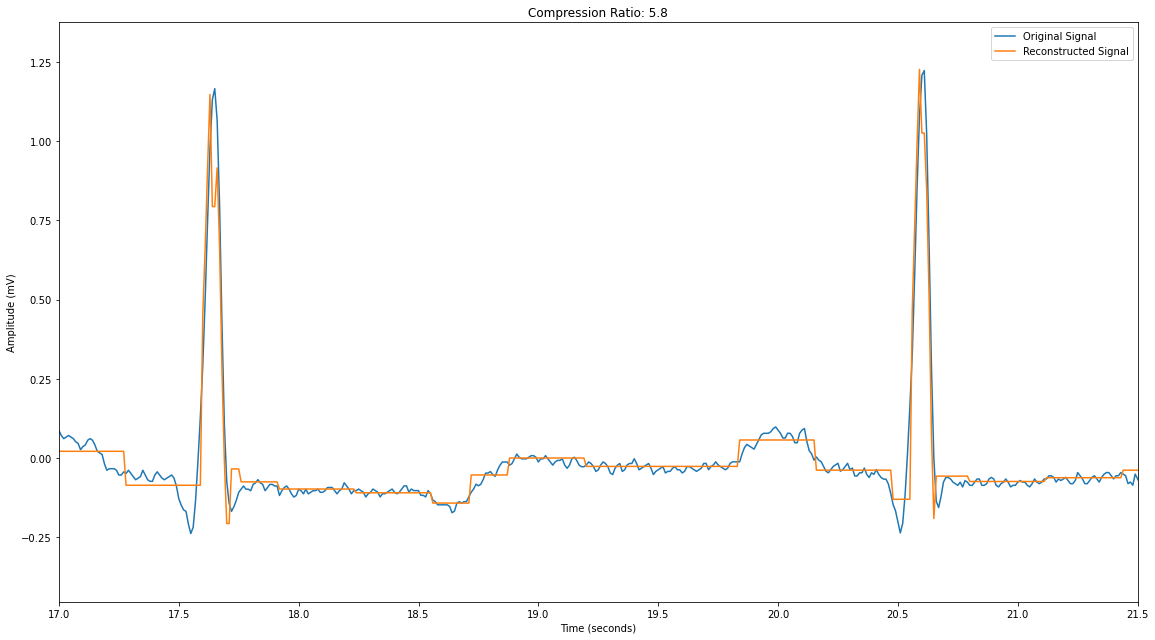

Average compression ratio: 6.0
Average PRD: 0.343


In [121]:
#load data
df = pd.read_pickle('mitdb.pkl')

#calculate the number of 10 second non-overlapping blocks of data
N = int(len(df)/NUM_SAMPLES_BLOCK) 
wavelet = 'haar'
#calculate the average CR and average PRD
CR_avg = 0
PRD_avg = 0

#plot stuff
do_plot = True

#loop over the data in 10 second chunks
for i in range(N):
    data = df.loc[i*NUM_SAMPLES_BLOCK:(i+1)*NUM_SAMPLES_BLOCK-1, 0].values

    #detrend the signal as a preprocessing step to remove unecessary information
    data = do_detrend(data, (i==1))

    #do wavelet decomposition 
    coeffs = wavelet_decomposition(data, wavelet)
    #threshold the coefficients such that 95% of the signal energy is retained
    #return nonzero thresholded coefficients, along with a binary map of zero/nonzero values
    #and a list of how many nonzero values were in each set of coefficients
    coeffs_thresholded, binary_map = threshold_energy(coeffs, do_plot=(i==1))

    #scale each set of wavelet coefficients between zero and one 
    #keep track of the scaling factors to re-scale to the original range later
    coeffs_scaled, scaling_factors = scale_coeffs(coeffs_thresholded, do_plot= False)

    #quantize the coefficients. choose the number of bits to quantize based on the PRD
    num_bits, PRD_tmp = calculate_num_bits(data, coeffs_scaled, scaling_factors, do_plot= False)
    PRD_avg = PRD_avg + PRD_tmp

    #get quantized coefficients
    coeffs_quantized = do_quantization(coeffs_scaled, num_bits, do_plot=(i==1))

    #combine all the quantized coefficients into a single array for compression
    #also combine all the binary maps into a single array for compression
    coeffs_quantized_combined = combine_coefficients(coeffs_quantized, binary_map)
    binary_map_combined = combine_coefficients(binary_map)
    #coeffs_quantized_compressed, num_bits_last_byte_coeffs = compress_coefficients(coeffs_quantized_combined, num_bits)
    source_code,coeffs_quantized_compressed = huff_encode(coeffs_quantized_combined)
    
    #compress the binary map
    binary_map_initial_state, binary_map_compressed, num_bits_last_byte_binary_map = compress_binary_map(binary_map_combined)

    #"transmit" all the necessary information to reconstruct the signal on the recieving end
    #this includes:
    #1. the compressed coefficients
    #2. the number of bits associated with the last byte of the compressed coefficients
    #3. the scaling factors for each wavelet decomposition
    #4. the number of bits used to quantize the coefficients
    #5. the compressed binary map
    #6. the number of bits associated with the last byte of the compressed binary map
    #7. the initial state of the binary map

    #calculate the compression ratio for this transmission
    CR_tmp = calculate_compression_ratio(coeffs_quantized_compressed, scaling_factors, binary_map_compressed, binary_map_initial_state)
    CR_avg = CR_avg + CR_tmp

    #decompress the binary map
    binary_map_decompressed = decompress_binary_map(binary_map_compressed, binary_map_initial_state, num_bits_last_byte_binary_map)

    #decompress the coefficients
    #coeffs_decompressed = decompress_coefficients(coeffs_quantized_compressed, num_bits, num_bits_last_byte_coeffs)
    coeffs_decompressed = huff_decode(source_code,coeffs_quantized_compressed)
    coeffs_decompressed = coeffs_decompressed.strip(" ")
    coeffs_decompressed = list(coeffs_decompressed.split(" "))
    for idx,_ in enumerate(coeffs_decompressed):
        coeffs_decompressed[idx] = int(coeffs_decompressed[idx])
    #remap all the coefficients back to their original wavelet decompositions
    coeffs_reconstructed = remap_coeffs(coeffs,coeffs_decompressed, binary_map_decompressed)

    #rescale the coefficients
    coeffs_unscaled = unscale_coeffs(coeffs, coeffs_reconstructed, scaling_factors, num_bits, do_plot=False)

    #do the inverse dwt
    data_reconstructed = wavelet_reconstruction(coeffs_unscaled, data,wavelet, CR_tmp, do_plot=(i==1))



#calculate the average compression ratio and PRD
CR_avg = CR_avg/N
PRD_avg = PRD_avg/N
print('Average compression ratio: %.1f' % CR_avg)
print('Average PRD: %.3f' % PRD_avg)

In [122]:
jovian.log_metrics(wavelet= wavelet , CR= round(CR_avg,1) , PRD = round(PRD_avg,3))

[jovian] Metrics logged.
